In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import poisson_disc as pd
from mpl_toolkits.mplot3d import Axes3D
import ipywidgets as widgets
import random

from ipywidgets import IntProgress
from IPython.display import display
import time


In [2]:
# Poisson disc sampling in arbitrary dimensions via Bridson algorithm
# Implementation by Pavel Zun, pavel.zun@gmail.com
# BSD licence - https://github.com/diregoblin/poisson_disc_sampling

# -----------------------------------------------------------------------------
# Based on 2D sampling by Nicolas P. Rougier - https://github.com/rougier/numpy-book
# -----------------------------------------------------------------------------

import numpy as np
from scipy.special import gammainc

# Uniform sampling in a hyperspere
# Based on Matlab implementation by Roger Stafford
# Can be optimized for Bridson algorithm by excluding all points within the r/2 sphere
def hypersphere_volume_sample(center,radius,k=1):
    ndim = center.size
    x = np.random.normal(size=(k, ndim))
    ssq = np.sum(x**2,axis=1)
    fr = radius*gammainc(ndim/2,ssq/2)**(1/ndim)/np.sqrt(ssq)
    frtiled = np.tile(fr.reshape(k,1),(1,ndim))
    p = center + np.multiply(x,frtiled)
    return p


# Uniform sampling on the sphere's surface
def hypersphere_surface_sample(center,radius,k=1):
    ndim = center.size
    vec = np.random.standard_normal(size=(k, ndim))
    vec /= np.linalg.norm(vec, axis=1)[:,None]
    p = center + np.multiply(vec, radius)
    return p


def squared_distance(p0, p1):
    return np.sum(np.square(p0-p1))

def Bridson_sampling(dims=np.array([1.0,1.0]), min_radius=0.05, max_radius=0.05, k=30, hypersphere_sample=hypersphere_volume_sample):
    # References: Fast Poisson Disk Sampling in Arbitrary Dimensions
    #             Robert Bridson, SIGGRAPH, 2007

    ndim=dims.size

    # size of the sphere from which the samples are drawn relative to the size of a disc (radius)
    sample_factor = 2
    if hypersphere_sample == hypersphere_volume_sample:
        sample_factor = 2
        
    # for the surface sampler, all new points are almost exactly 1 radius away from at least one existing sample
    # eps to avoid rejection
    if hypersphere_sample == hypersphere_surface_sample:
        eps = 0.001
        sample_factor = 1 + eps
    
    def in_limits(p):
        return np.all(np.zeros(ndim) <= p) and np.all(p < dims)

    # Check if there are samples closer than "squared_radius" to the candidate "p"
    def in_neighborhood(p, n=2):
        indices = (p / cellsize).astype(int)
        indmin = np.maximum(indices - n, np.zeros(ndim, dtype=int))
        indmax = np.minimum(indices + n + 1, gridsize)
        
        # Check if the center cell is empty
        if not np.isnan(P[tuple(indices)][0]):
            return True
        a = []
        for i in range(ndim):
            a.append(slice(indmin[i], indmax[i]))
        with np.errstate(invalid='ignore'):
            if np.any(np.sum(np.square(p - P[tuple(a)]), axis=ndim) < squared_radius):
                return True

    def add_point(p):
        points.append(p)
        indices = (p/cellsize).astype(int)
        P[tuple(indices)] = p

    cellsize = min_radius/np.sqrt(ndim)
    gridsize = (np.ceil(dims/cellsize)).astype(int)

    # Positions of cells
    P = np.empty(np.append(gridsize, ndim), dtype=np.float32) #n-dim value for each grid cell
    # Initialise emptsy cells with NaNs
    P.fill(np.nan)

    points = []
    add_point(np.random.uniform(np.zeros(ndim), dims))
    while len(points):
        i = np.random.randint(len(points))
        p = points[i]
        del points[i]
        radius = np.random.uniform(min_radius, max_radius)
        # Squared radius because we'll compare squared distance
        squared_radius = radius * radius
        Q = hypersphere_sample(np.array(p), radius * sample_factor, k)
        for q in Q:
            if in_limits(q) and not in_neighborhood(q):
                add_point(q)
    return P[~np.isnan(P).any(axis=ndim)]

In [3]:
# # default: 2D points, classic Bridson algorithm as described here:
# # https://www.cs.ubc.ca/~rbridson/docs/bridson-siggraph07-poissondisk.pdf
# points = Bridson_sampling()

# fig, ax = plt.subplots(1, 2, figsize=(10,20))

# # alternative sampler, results in denser points: 
# # based on the method proposed here by Martin Roberts: http://extremelearning.com.au/an-improved-version-of-bridsons-algorithm-n-for-poisson-disc-sampling/
# dims2d = np.array([1.0,1.0])
# points_surf1 = Bridson_sampling(dims=dims2d, min_radius=0.04, max_radius=0.04, k=30, hypersphere_sample=hypersphere_surface_sample)
# points_surf2 = Bridson_sampling(dims=dims2d, min_radius=0.04, max_radius=0.01, k=30, hypersphere_sample=hypersphere_surface_sample)
# print(len(points_surf1))
# print(len(points_surf2))

# np.random.shuffle(points_surf1)
# np.random.shuffle(points_surf2)


# ax[0].scatter(points_surf1[:,0], points_surf1[:,1], s=10)
# ax[0].set_xlim(0, 1)
# ax[0].set_ylim(0, 1)
# ax[0].set_aspect('equal')

# ax[1].scatter(points_surf2[:,0], points_surf2[:,1], s=10)
# ax[1].set_xlim(0, 1)
# ax[1].set_ylim(0, 1)
# ax[1].set_aspect('equal')

In [4]:
# radius = .05
# dims2d = np.array([1.0,1.0])
# points = pd.Bridson_sampling(dims=dims2d, min_radius=radius, max_radius=radius, k=30, hypersphere_sample=pd.hypersphere_surface_sample)
# vec = np.random.randn(2, len(points))
# vec /= np.linalg.norm(vec, axis=0)
# jitter = np.column_stack((vec[0], vec[1])) * radius

# print(jitter.shape)

# # jittera = np.random.uniform(-radius*.5, radius*.5, len(points))
# # jitterb = np.random.uniform(-radius*.5, radius*.5, len(points))
# # jitter = np.column_stack((jittera, jitterb))
# # print(points.shape)
# # print(jitter.shape)
# pointsB = points + jitter

# def plot(x):
#     pointsB = points + jitter * x
#     tri = Delaunay(pointsB)
#     plt.triplot(pointsB[:,0], pointsB[:,1], tri.simplices)
#     plt.plot(pointsB[:,0], pointsB[:,1], 'o')
#     # plt.show()
 
# widgets.interact(plot, x=(0, 1, .01))

In [5]:
# 3D points
radius = .01
dims3d = np.array([1.0,1.0,1.0])
points3d = pd.Bridson_sampling(dims3d, min_radius=radius, max_radius=radius, k=30)

In [42]:
len(points)

563020

In [53]:
jitter = np.random.randn(3, len(points3d))
jitter /= np.linalg.norm(jitter, axis=0)
jitter = np.column_stack((jitter[0], jitter[1], jitter[2])) * radius * 10

samples = 100
for i in range(0, samples):
    x = i / float(samples)
    points = points3d + jitter * x

    attributes = np.arange(0, len(points)).reshape((len(points),1))
    points = np.hstack((points, attributes)).astype('float32')

    size = len(points3d)
    newFile = open("test_" + str(i).zfill(3) + ".points", "wb")
    newFile.write(size.to_bytes(8, 'little'))

    newFile.write(points.tobytes())

    newFile.close()
    
    


# def plot(x):
    
#     fig3d = plt.figure()
#     ax3d = Axes3D(fig3d)
#     ax3d.scatter(points[:,0], points[:,1], points[:,2])
#     # plt.show()
 
# widgets.interact(plot, x=(0, 1, .01))

In [32]:
a = np.array([[1,2,3], [4, 5, 6]])
b = np.array([[8], [9]])

c = np.hstack((a, b))

In [52]:
points.dtype

dtype('float32')

In [26]:
points = points3d + jitter * 0
tets = Delaunay(points)

In [35]:
len(tets.simplices)

3667818

In [13]:
radius

0.01

In [15]:
print("computing points")
radius = .005
dims3d = np.array([1.0,1.0,1.0])
points3d = pd.Bridson_sampling(dims3d, min_radius=radius, max_radius=radius, k=30)

print("done, now jittering...")
jitter = np.random.randn(3, len(points3d))
jitter /= np.linalg.norm(jitter, axis=0)
jitter = np.column_stack((jitter[0], jitter[1], jitter[2])) * radius

from ipywidgets import IntProgress
from IPython.display import display
for amount in range(0, 10, 1):
    mesh = UMesh.CreateUMesh()

    points = points3d + jitter * float(amount) / 10.0
    tets = Delaunay(points)

    # indices
    f = IntProgress(min=0, max=len(tets.simplices)) # instantiate the bar
    display(f) # display the bar

    mesh.tets.resize((len(tets.simplices)))

    for i in range(len(tets.simplices)):
        if (i % 100) == 0 : f.value += 100
        indices = [
            int(tets.simplices[i][0]), 
            int(tets.simplices[i][1]), 
            int(tets.simplices[i][2]), 
            int(tets.simplices[i][3])]
        mesh.tets[i].set_indices(indices)

    # vertices
    from ipywidgets import IntProgress
    from IPython.display import display
    f = IntProgress(min=0, max=len(tets.points)) # instantiate the bar
    display(f) # display the bar

    mesh.vertices.resize((len(tets.points)))

    for i in range(len(tets.points)):
        if (i % 100) == 0 : f.value += 100
        mesh.vertices[i] = tets.points[i]

    # scalars
    from ipywidgets import IntProgress
    from IPython.display import display
    f = IntProgress(min=0, max=len(tets.points)) # instantiate the bar
    display(f) # display the bar

    mesh.perVertex.values.resize(len(tets.points))

    for i in range(len(tets.points)):
        if (i % 100) == 0 : f.value += 100
        x = 1 - pow(tets.points[i][0] * 2 - 1, 2)
        y = 1 - pow(tets.points[i][1] * 2 - 1, 2)
        z = 1 - pow(tets.points[i][2] * 2 - 1, 2)
        scalar = x * y * z
        mesh.perVertex.values[i] = scalar

    path = "./test" + str(amount) + ".umesh"
    UMesh.saveBinaryUMesh(path, mesh)

computing points
done, now jittering...


IntProgress(value=0, max=29232219)

IntProgress(value=0, max=4479287)

IntProgress(value=0, max=4479287)

IntProgress(value=0, max=29260319)

IntProgress(value=0, max=4479287)

IntProgress(value=0, max=4479287)

IntProgress(value=0, max=29356267)

IntProgress(value=0, max=4479287)

IntProgress(value=0, max=4479287)

IntProgress(value=0, max=29535718)

IntProgress(value=0, max=4479287)

IntProgress(value=0, max=4479287)

IntProgress(value=0, max=29789824)

IntProgress(value=0, max=4479287)

IntProgress(value=0, max=4479287)

IntProgress(value=0, max=30063254)

IntProgress(value=0, max=4479287)

IntProgress(value=0, max=4479287)

IntProgress(value=0, max=30261135)

IntProgress(value=0, max=4479287)

IntProgress(value=0, max=4479287)

IntProgress(value=0, max=30352242)

IntProgress(value=0, max=4479287)

IntProgress(value=0, max=4479287)

IntProgress(value=0, max=30371928)

IntProgress(value=0, max=4479287)

IntProgress(value=0, max=4479287)

IntProgress(value=0, max=30359644)

IntProgress(value=0, max=4479287)

IntProgress(value=0, max=4479287)

In [71]:


max_count = 100

f = IntProgress(min=0, max=max_count) # instantiate the bar
display(f) # display the bar

count = 0
while count <= max_count:
    f.value += 1 # signal to increment the progress bar
    time.sleep(.1)
    count += 1

IntProgress(value=0)

(100000, 3)


C:\Users\Nate\AppData\Local\Temp\ipykernel_4464\3832539063.py:24: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax3d = Axes3D(fig3d)


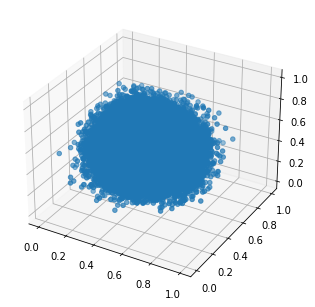

In [30]:
mean = 0.
sigma = 100.0
numPoints = 1000000
y = np.random.poisson(sigma, numPoints)
x = np.random.poisson(sigma, numPoints)
z = np.random.poisson(sigma, numPoints)
x -= np.min(x)
y -= np.min(y)
z -= np.min(z)
x = x / np.max(x)
y = y / np.max(y)
z = z / np.max(z)
pointsB = np.column_stack((x, y, z))
print(pointsB.shape)

# tets = Delaunay(pointsB)
# plt.triplot(pointsB[:,0], pointsB[:,1], tri.simplices)
# plt.plot(pointsB[:,0], pointsB[:,1], 'o')
# plt.show()
 
# widgets.interact(plot, lam=(1, 100, .01))

fig3d = plt.figure()
ax3d = Axes3D(fig3d)
ax3d.scatter(x, y, z)
plt.show()

In [31]:
tets = Delaunay(pointsB)

In [34]:


# assumes tets generated above
mesh = UMesh.CreateUMesh()

# indices
f = IntProgress(min=0, max=len(tets.simplices)) # instantiate the bar
display(f) # display the bar

mesh.tets.resize((len(tets.simplices)))

for i in range(len(tets.simplices)):
    if (i % 100) == 0 : f.value += 100
    indices = [
        int(tets.simplices[i][0]), 
        int(tets.simplices[i][1]), 
        int(tets.simplices[i][2]), 
        int(tets.simplices[i][3])]
    mesh.tets[i].set_indices(indices)

# vertices
from ipywidgets import IntProgress
from IPython.display import display
f = IntProgress(min=0, max=len(tets.points)) # instantiate the bar
display(f) # display the bar

mesh.vertices.resize((len(tets.points)))

for i in range(len(tets.points)):
    if (i % 100) == 0 : f.value += 100
    mesh.vertices[i] = tets.points[i]

# scalars
from ipywidgets import IntProgress
from IPython.display import display
f = IntProgress(min=0, max=len(tets.points)) # instantiate the bar
display(f) # display the bar

mesh.perVertex.values.resize(len(tets.points))

for i in range(len(tets.points)):
    if (i % 100) == 0 : f.value += 100
    x = 1 - pow(tets.points[i][0] * 2 - 1, 2)
    y = 1 - pow(tets.points[i][1] * 2 - 1, 2)
    z = 1 - pow(tets.points[i][2] * 2 - 1, 2)
    scalar = x * y * z
    mesh.perVertex.values[i] = scalar

path = "./poisson.umesh"
UMesh.saveBinaryUMesh(path, mesh)

IntProgress(value=0, max=334158)

IntProgress(value=0, max=100000)

IntProgress(value=0, max=100000)